# Generating catalogs with SkyCatalog

This is a demonstration of using the `SkyCatalog` class to generate catalogs of sky positions over parts of the sky

## Overview

The `SkyCatalogue` class generates a list of RA / DEC coordinates of "dark sky" positions greater than some distance (20 arcsec default) away from any objects brighter than 21 magnitude, using object data from the [Legacy Survey Data Release 10](https://www.legacysurvey.org/dr10/description/) Tractor catalog through querying the [NOIRLAb Astro Data Lab](https://datalab.noirlab.edu/index.php).

## Imports and dependencies

The SkyCatalog class uses functionality from Astropy, Numpy, Pandas, sklearn, matplotlib, and the NOIRLab Astro Data Lab. 

Because of dependency requirements for the Astro Data Lab, it's recommended to use Numpy version 1.26.3 specifically. 

In [1]:
# the jupyter kernel needs to be reset if changes are made to the class
%load_ext autoreload
%autoreload 2

from catalog_class import SkyCatalogue

# these are only necessary for display purposes in this notebook
import matplotlib.pyplot as plt
import numpy as np

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Initialization

First, initialize the object with arguments to describe the properties of the resulting dark sky catalogue:

`bands` *(default = 'g', 'r', 'i','z')*: List of LSDR10 filters used to determine object magnitudes. Possible options include any combination of 'g', 'r', 'i', and 'z'. Note that some objects in the catalog are only detected in certain filters, especially the "reddest" filters, so the combination of filters used can heavily affect the number of dark sky positions generated. These bands can be changed later as keyword arguments into the individual methods as well as needed.

`map_dist` *(default = 1 degree)*: The size of one side of the unit-square level analysis during the dark sky identification algorithm. One degree or less is recommended.

`mask_radius` *(default = 20 arcseconds)*: Minimum distance from an object that a "dark sky position" is allowed to occur at. All objects will have masks with a radius of at least `mask_value`.

`fov` *(default = 45 arcseconds)*: Spacing of the grid used to calculate dark positions within the `map_dist` scale analysis, so this is also the minimum spacing between dark sky position coordinates.

Initialize with minimum object masking radius (default = 20 arcsec), spacing between dark sky positions (default = 45 arsec), dimension of segmentation map analysis (default = 1 degree), and DR10 wavebands to use in addition to g (g, r, i, z)

In [2]:
# TODO: make it so you can select which bands to use?

catalog = SkyCatalogue(bands=('g'),verbose=True)
ra = 0
dec = -30
# catalog_g_band = SkyCatalogue(bands=('g'))

Initialising...
Loading masked star data....
Defining grid lines...
Creating KDTree for distance calculations...
KDTree created!
Initialisation complete!


Sky positions can be generated on multiple different levels:
- Single degree (1 x 1) squares using an externally provided dataframe of star ra/dec and mask radius to work from
- Single query (n x n degree) square split up into single-degree chunks
- "Full sky" split up into (n x n degree) square queries, with each of those also split into single-degree chunks

In [ ]:
# single degree
# # query LSDR10 catalog from NOIRLab Astro Data Lab
# query_df = catalog.query_tractor(ra, dec)
# single_degree_catalog, overlap = catalog.create_degree_square(ra, dec, query_df, plot_image=True)
# print(f"Positions found: {single_degree_catalog.size}")

>> Querying the tractor catalog for stars from RA/DEC(0, -30) to (1.0, -29.0)...
>>>> Combining mask and queried stars...
>>>> Calculating pixel values for stars....
>>>> Creating segmentation map...
>>>> Finding dark regions in segmentation map...
>>>> Plotting dark regions...


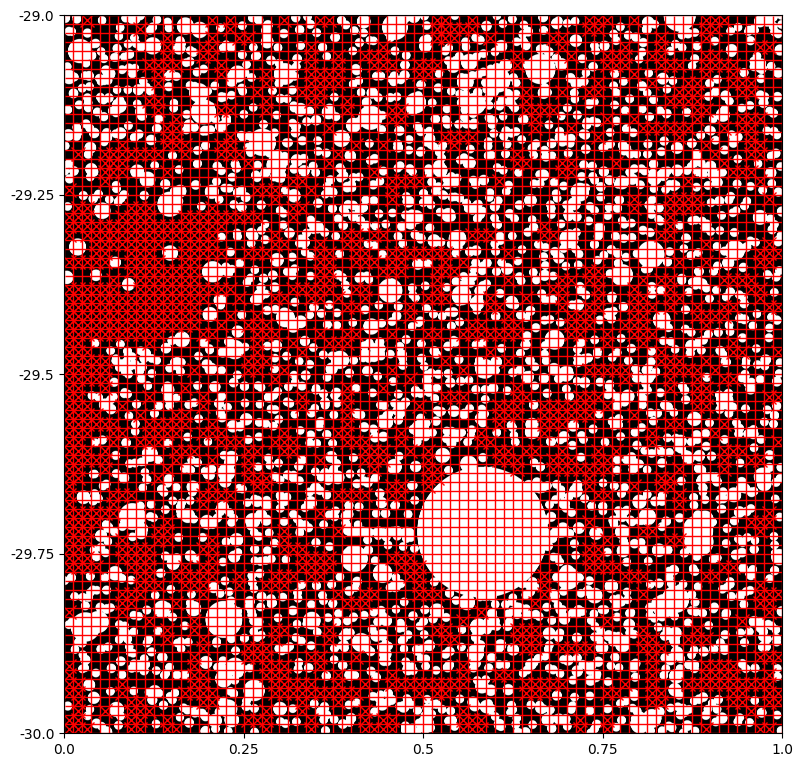

>>>> Converting dark regions to coordinates...
>>>> Finding maximum extent of stars beyond the degree-square bounds...
>>>> Done!


In [5]:
# single degree
# query LSDR10 catalog from NOIRLab Astro Data Lab
# catalog.bands = ('g')
# query_df = catalog.query_tractor(ra, dec, bands=('g'))
catalog.mode='corner'
single_degree_catalog, overlap = catalog.create_degree_square(ra, dec, plot_image=True, add_query=True)
# print(f"Positions found: {single_degree_catalog.size}")

In [ ]:
# multiple degrees
# 2x2 degree query square with all bands (griz) = 73.34 s
# this finds 218 dark sky positions in that area
positions_allbands = catalog.create_catalogue(ra, dec, 2, bands=('g', 'r', 'i', 'z'))

# 2x2 degree query square with just g band = 37.66 s
# this finds 9716 dark sky positions in that area
positions_gband = catalog.create_catalogue(ra, dec, 2, bands=('g'))
positions_grbands = catalog.create_catalogue(ra, dec, 2, bands=('g', 'r'))
positions_gribands = catalog.create_catalogue(ra, dec, 2, bands=('g', 'r', 'i'))

In [ ]:
# difference between griz and g band in the same area
print(f"Positions found (griz): {positions_allbands.size}")
print(f"Positions found (gri): {positions_gribands.size}")
print(f"Positions found (gr): {positions_grbands.size}")
print(f"Positions found (g): {positions_gband.size}")

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].plot(positions_allbands['ra'], positions_allbands['dec'], 'k.')
ax[0,0].set(title=f"griz bands ({positions_allbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[0,1].plot(positions_gribands['ra'], positions_gribands['dec'], 'b.')
ax[0,1].set(title=f"gri bands ({positions_gribands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,0].plot(positions_grbands['ra'], positions_grbands['dec'], 'r.')
ax[1,0].set(title=f"gr bands ({positions_grbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,1].plot(positions_gband['ra'], positions_gband['dec'], 'g.')
ax[1,1].set(title=f"g bands ({positions_gband.size} positions)", xlabel="RA", ylabel="DEC")

fig.tight_layout()
fig.suptitle("Comparison of Available Dark Sky Positions by Band", fontsize='xx-large')
fig.subplots_adjust(top=0.91)

plt.show()

In [ ]:
# generate "whole sky"
# positions_allsky_gband = catalog_g_band.all_sky(query_dist=2.0)

# generate sections of the whole sky
catalog.mode = 'centre'
positions_allsky_gband = catalog.all_sky(ra_allsky=3, dec_allsky=-4, sky_dist=4, query_dist=2.0, bands=('g', 'r', 'i'), mode='centre')

In [ ]:
fig, ax = plt.subplots()
ax.plot(positions_allsky_gband['ra'], positions_allsky_gband['dec'], 'g.')
ax.set(title=f"gri bands ({positions_allsky_gband.size} positions)", xlabel="RA", ylabel="DEC")
plt.tight_layout()
plt.show()

Whole sky generation avoids the Galactic plane (within |b| > 18) and the LMC / SMC, and simply does not run the dark sky finding algorithms on the degree-level squares that intersect with those boundaries.

## Characterizing distances

In [ ]:
from sklearn.neighbors import KDTree

# generate random list of (ra, dec) positions within the bounds of that square
random_ra = np.random.uniform(ra, ra+2, size=10000)
random_dec = np.random.uniform(dec, dec+2, size=10000)

# find closest point to that ra/dec pair
points = np.asarray([random_ra, random_dec]).T
griz_tree = KDTree(np.asarray([positions_allbands['ra'], positions_allbands['dec']]).T)
gri_tree = KDTree(np.asarray([positions_gribands['ra'], positions_gribands['dec']]).T)
gr_tree = KDTree(np.asarray([positions_grbands['ra'], positions_grbands['dec']]).T)
g_tree = KDTree(np.asarray([positions_gband['ra'], positions_gband['dec']]).T)

griz_dist, griz_nearest = griz_tree.query(points, 1, return_distance=True)
gri_dist, gri_nearest = gri_tree.query(points, 1, return_distance=True)
gr_dist, gr_nearest = gr_tree.query(points, 1, return_distance=True)
g_dist, g_nearest = g_tree.query(points, 1, return_distance=True)

In [ ]:
griz_avg = np.average(griz_dist)*60
gri_avg = np.average(gri_dist)*60
gr_avg = np.average(gr_dist)*60
g_avg = np.average(g_dist)*60


fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].hist(griz_dist*60, bins=50, color='k')
ax[0,0].vlines(griz_avg, ymin=0, ymax=50, color='y')
ax[0,0].set(title=f"griz distances (average={griz_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[0,1].hist(gri_dist*60, bins=50, color='b')
ax[0,1].vlines(gri_avg, ymin=0, ymax=50, color='y')
ax[0,1].set(title=f"gri distances (average={gri_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[1,0].hist(gr_dist*60, bins=50, color='r')
ax[1,0].vlines(gr_avg, ymin=0, ymax=50, color='y')
ax[1,0].set(title=f"gr distances (average={gr_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

ax[1,1].hist(g_dist*60, bins=50, color='g')
ax[1,1].vlines(g_avg, ymin=0, ymax=50, color='y')
ax[1,1].set(title=f"g distances (average={g_avg:.2f} arcmin)", xlabel="distance (arcmin)", ylabel="count")

fig.tight_layout()
fig.suptitle("Average distance to closest sky position by band", fontsize='xx-large')
fig.subplots_adjust(top=0.91)
plt.show()

In [ ]:
# difference between griz and g band in the same area
print(f"Positions found (griz): {positions_allbands.size}")
print(f"Positions found (gri): {positions_gribands.size}")
print(f"Positions found (gr): {positions_grbands.size}")
print(f"Positions found (g): {positions_gband.size}")

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].plot(positions_allbands['ra'], positions_allbands['dec'], 'k.')
ax[0,0].plot(random_ra, random_dec, 'rx')
ax[0,0].set(title=f"griz bands ({positions_allbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[0,1].plot(positions_gribands['ra'], positions_gribands['dec'], 'b.')
ax[0,1].plot(random_ra, random_dec, 'rx')
ax[0,1].set(title=f"gri bands ({positions_gribands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,0].plot(positions_grbands['ra'], positions_grbands['dec'], 'r.')
ax[1,0].plot(random_ra, random_dec, 'rx')
ax[1,0].set(title=f"gr bands ({positions_grbands.size} positions)", xlabel="RA", ylabel="DEC")

ax[1,1].plot(positions_gband['ra'], positions_gband['dec'], 'g.')
ax[1,1].plot(random_ra, random_dec, 'rx')
ax[1,1].set(title=f"g bands ({positions_gband.size} positions)", xlabel="RA", ylabel="DEC")

fig.tight_layout()
fig.suptitle("Comparison of Available Dark Sky Positions by Band", fontsize='xx-large')
fig.subplots_adjust(top=0.91)

plt.show()